In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools

import numpy as np
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.interpolate import griddata

from src import depth

# Cubical Torus

In [3]:
def array_to_tuple(arr):
    if isinstance(arr, np.ndarray):
        return tuple(array_to_tuple(sub) for sub in arr)
    else:
        return int(arr)

In [4]:
# Example
a = np.array([[1, 2], [3, 4]])
t = array_to_tuple(a)
print(t)  # Output: ((1, 2), (3, 4))

((1, 2), (3, 4))


In [5]:
def contains_subtuple(tup, sub):
    n, m = len(tup), len(sub)
    for i in range(n - m + 1):
        if tup[i:i + m] == sub:
            return True
    return False


In [6]:
# Example

t = (1, 2, 3, 4, 5)
sub = (3, 4)
print(contains_subtuple(t, sub))  # True
print(contains_subtuple(sub, t))  # False

t = (1, 2, 3, 4, 5)
sub = (3, 5)
print(contains_subtuple(t, sub))  # False

True
False
False


In [7]:
class CubicalTorusComplex():
    def __init__(self, shape, dim=None, vector_sets=None):
        """
        """
        if dim is None:
            dim = len(shape)
        else:
            shape = np.array(shape)[:dim]
        self.shape = tuple(shape)
        self.dim = int(dim)

        if vector_sets is None:
            # Defines the orientation of cells
            self.vector_sets = [np.unique(list(itertools.permutations(np.concatenate([np.zeros(dim - i, dtype=bool), 
                                                                                      np.ones(i, dtype=bool)]))), axis=0) for i in range(dim + 1)]
        else:
            self.vector_sets = list(vector_sets)
        
    def assign_filtration(self, filtration_values: list):
        """
        Assign the filtration values of cubical simplex

        Parameters:
        -----------
        filtration_values: list of self.dim + 1 np.arrays each i-th should have shape (comb(self.dim, i), self.chape)
            The i-th matrix coresponds the filtration values of i-skeleton of the Complex. 
            The orientation of the cells is defined by self.vector_sets
        """
        self.filtration_values = filtration_values
        return self
    
    def assign_random_barycentric_filtration(self, levels=None):
        """

        """
        if levels is None:
            levels = np.arange(self.dim + 2)
        filtration_values = [levels[i] + np.random.random(np.append(len(vector_set), self.shape))*(levels[i + 1] - levels[i]) for i, vector_set in enumerate(self.vector_sets)]
        self.assign_filtration(filtration_values)
        return self
    
    def assign_height_filtration(self, filtration_values):
        """
        """
        filtration_values = np.asarray(filtration_values)
        if filtration_values.shape != self.shape:
            raise ValueError(f'The filtrtation values matrix should have shape {self.shape}')
        pass
    
    def draw_strong(self, cmap='jet', vmin=None, vmax=None, ax=None, all_borders=True, zorder=0):
        """
        """
        if self.dim != 2:
            return
        if ax is None:
            ax = plt.gca()
        if vmin is None:
            vmin = self.filtration_values[0].min()
        if vmax is None:
            vmax = self.filtration_values[-1].max()
        norm = Normalize(vmin=vmin, vmax=vmax)
        cmap = plt.get_cmap(cmap)
        sm = ScalarMappable(cmap=cmap, norm=norm)

        matrix = self.filtration_values[0][0]
        for x0, x1 in itertools.product(np.arange(self.shape[0]), np.arange(self.shape[1])):
            color = cmap(norm(matrix[x0, x1]))
            ax.scatter(x0, x1, color=color, zorder=2)
            x = np.array([x0, x1])
            if x0 == 0 and all_borders:
                ax.scatter(self.shape[0], x1, color=color, zorder=2 + zorder)
            if x1 == 0 and all_borders:
                ax.scatter(x0, self.shape[1], color=color, zorder=2 + zorder)
            if (x0 == 0) and (x1 == 0) and all_borders:
                ax.scatter(self.shape[0], self.shape[1], color=color, zorder=2 + zorder)

        
        for (v0, v1), matrix in zip(self.vector_sets[1], self.filtration_values[1]):
            for x0, x1 in itertools.product(np.arange(self.shape[0]), np.arange(self.shape[1])):
                color = cmap(norm(matrix[x0, x1]))
                ax.plot([x0, x0 + v0], [x1, x1 + v1], color=color, zorder=1 + zorder, linewidth=4)
                if x0 == 0 and all_borders:
                    ax.plot([self.shape[0], self.shape[0]], [x1, x1 + v1], color=color, zorder=1 + zorder, linewidth=4)
                if x1 == 0 and all_borders:
                    ax.plot([x0, x0 + v0], [self.shape[1], self.shape[1]], color=color, zorder=1 + zorder, linewidth=4)
                        
        matrix = self.filtration_values[2][0]
        for x0, x1 in itertools.product(np.arange(self.shape[0]), np.arange(self.shape[1])):
            color = cmap(norm(matrix[x0, x1]))
            ax.fill_between(np.arange(2) + x0, np.zeros(2) + x1, np.zeros(2) + x1 + 1, color=color, zorder=0 + zorder)
        
        return sm
    
    def draw_gradiental(self, cmap='jet', vmin=None, vmax=None, ax=None, method='cubic', n=300):
        """
        """
        if self.dim != 2:
            return
        if ax is None:
            ax = plt.gca()
        if vmin is None:
            vmin = self.filtration_values[0].min()
        if vmax is None:
            vmax = self.filtration_values[-1].max()

        norm = Normalize(vmin=vmin, vmax=vmax)
        cmap = plt.get_cmap(cmap)
        sm = ScalarMappable(cmap=cmap, norm=norm)

        points0 = np.array(list(itertools.product(np.arange(self.shape[0]), np.arange(self.shape[1]))))
        heights0 = np.concatenate(self.filtration_values[0][0])
        points1 = np.concatenate([points0 + 0.5*np.array(vector) for vector in self.vector_sets[1]])
        heights1 = np.concatenate(np.concatenate(self.filtration_values[1]))
        points2 = points0 + 0.5*np.ones(2)
        heights2 = np.concatenate(self.filtration_values[2][0])
        points = np.concatenate([points0, points1, points2])
        heights = np.concatenate([heights0, heights1, heights2])

        heights_add = heights[(points[:, 0] == 0) | (points[:, 1] == 0)]
        points_add = points[(points[:, 0] == 0) | (points[:, 1] == 0)]
        points_add[points_add[:, 0] == 0, 0] = self.shape[0]
        points_add[points_add[:, 1] == 0, 1] = self.shape[1]

        points_zero = [(self.shape[0], 0), (0, self.shape[1])]
        heights_zero = np.ones(2)*self.filtration_values[0][0][0, 0]

        points = np.concatenate([points, points_add, points_zero])
        heights = np.concatenate([heights, heights_add, heights_zero])

        x, y = points[:, 0], points[:, 1]
        grid_x, grid_y = np.meshgrid(
            np.linspace(x.min(), x.max(), n),
            np.linspace(y.min(), y.max(), n)
        )
        grid_z = griddata(points, heights, (grid_x, grid_y), method=method)
        
        ax.imshow(grid_z, extent=(x.min(), x.max(), y.min(), y.max()), cmap=cmap, norm=norm, aspect='auto')
        return sm

    def get_order(self, sort_with_filtration=True, map=array_to_tuple, return_filtration=False, return_dims=False):
        """
        """
        order = []
        
        basis = np.eye(self.dim, dtype=int)
        for celldim, vectorset in enumerate(self.vector_sets):
            for vector in vectorset:
                # Ебать, я тут хуйню наворотил! В общем, это - координаты клетки в нуле.
                zerocell = np.array([np.zeros(self.dim, dtype=int) if np.logical_not(i).all() else basis[vector][list(i)].sum(axis=0) for i in itertools.product([False, True], repeat=celldim)])
                for point in itertools.product(*[np.arange(n) for n in self.shape]):
                    cell = zerocell + np.array(point)
                    cell %= np.array(self.shape)
                    cell = map(cell)
                    order.append(cell)

        dims = np.concatenate([celldim + np.zeros(np.prod(matrix.shape), dtype=int) for celldim, matrix in enumerate(self.filtration_values)])
        values = np.concatenate([matrix.flatten() for matrix in self.filtration_values])
        
        if sort_with_filtration:
            indices = np.lexsort((dims, values))
            dims = dims[indices]
            values = values[indices]
            order = list(np.array(order, dtype=object)[indices])
        


        if (not return_filtration) and (not return_dims):
            return order
        result = [order]
        if return_dims:
            result.append(dims)
        if return_filtration:
            result.append(values)
        return tuple(result)


    def get_border_matrix(self, sort_with_filtration=True, dtype=int):
        """
        """
        # Очень неэффективное решение, но должно работать!
        # This works incorrectly if self.shape contains n <= 2
        order, dims = self.get_order(map = lambda s: set(array_to_tuple(s)), return_dims=True, sort_with_filtration=sort_with_filtration)
        order = np.array(order, dtype=object)
        f = np.vectorize(lambda s0, s1: (s0 & s1) == s0)
        matrix = f(order.reshape(-1, 1), order.reshape(1, -1)) & (dims.reshape(-1, 1) - dims.reshape(1, -1) == -1)
        matrix = matrix.astype(dtype)

        return matrix

    def get_depth_poset(self, sort_with_filtration=True) -> depth.DepthPoset:
        """
        """
        order, dims, fvals = self.get_order(sort_with_filtration=sort_with_filtration, return_dims=True, return_filtration=True)
        if not sort_with_filtration:
            fvals = np.arange(len(order))
        bm = self.get_border_matrix(sort_with_filtration=sort_with_filtration)
        dp = depth.DepthPoset.from_border_matrix(border_matrix=bm, dims=dims, filter_values=fvals, sources=order)
        return dp

        

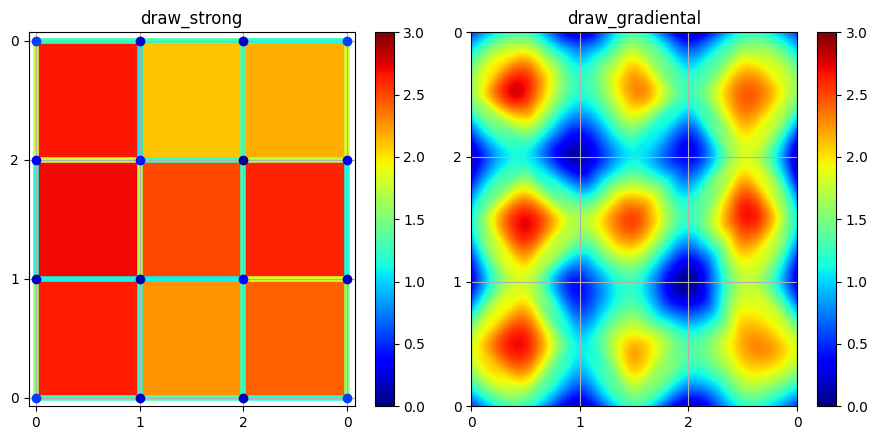

In [8]:
shape = 3, 3

ctc = CubicalTorusComplex(shape)
ctc.assign_random_barycentric_filtration()

if len(shape) == 2:
    fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))

    axs[0].set_title('draw_strong')
    sm0 = ctc.draw_strong(ax=axs[0], vmin=0, vmax=len(shape) + 1)
    axs[1].set_title('draw_gradiental')
    sm1 = ctc.draw_gradiental(ax=axs[1], vmin=0, vmax=len(shape) + 1)

    for i in range(2):
        axs[i].set_xticks(np.arange(shape[0] + 1), labels=np.arange(shape[0] + 1)%shape[0])
        axs[i].set_yticks(np.arange(shape[1] + 1), labels=np.arange(shape[1] + 1)%shape[1])
        axs[i].grid(True)

    eps = 0.07
    axs[0].set_xlim(0 - eps, shape[0] + eps)
    axs[0].set_ylim(0 - eps, shape[1] + eps)

    plt.colorbar(sm0, ax=axs[0])
    plt.colorbar(sm1, ax=axs[1])
    plt.tight_layout()
    plt.show()


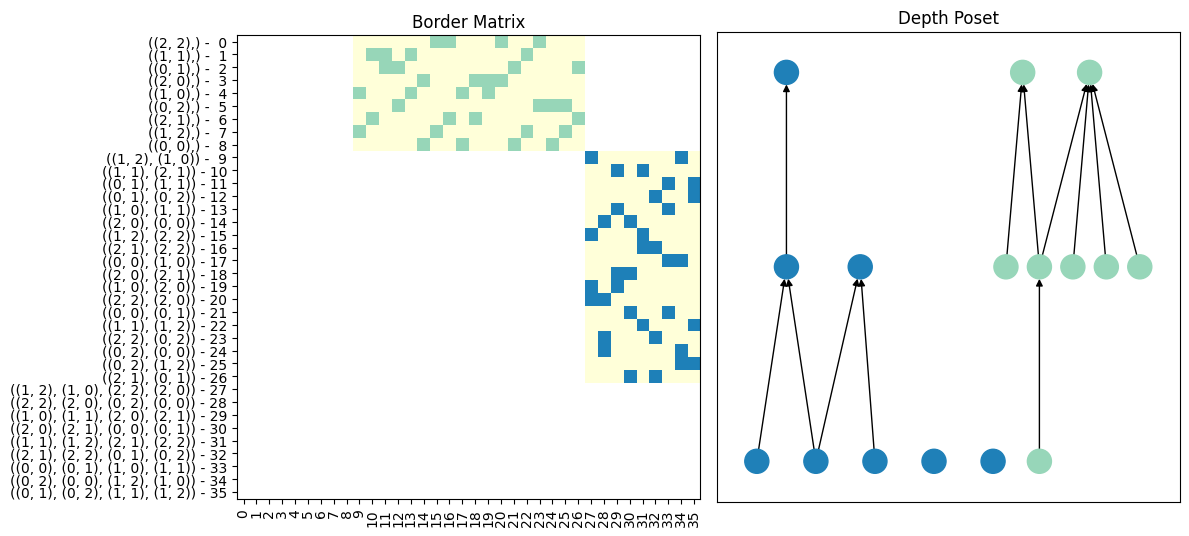

In [9]:
sort_with_filtration = True

order, dims, fvals = ctc.get_order(sort_with_filtration=sort_with_filtration, return_dims=True, return_filtration=True)
bm = ctc.get_border_matrix(sort_with_filtration=sort_with_filtration)
dp = ctc.get_depth_poset(sort_with_filtration=sort_with_filtration)

bm_show = bm.astype(float)*dims
bm_show[dims.reshape(-1, 1) - dims.reshape(1, -1) != -1] = np.nan




fig, axs = plt.subplots(1, 2, figsize=(12, 5.5))
cmap = plt.get_cmap('YlGnBu')

axs[0].set_title('Border Matrix')
axs[0].imshow(bm_show, cmap=cmap, vmax=3)
axs[0].set_yticks(np.arange(len(order)), [f'{val} -{i:>3}' for i, val in enumerate(order)], rotation=0)
axs[0].set_xticks(np.arange(len(order)), np.arange(len(order)), rotation=90)

axs[1].set_title('Depth Poset')
g = dp.get_transitive_reduction()
pos = {node: (x, -y) for node, (x, y) in nx.nx_agraph.graphviz_layout(g, prog="dot", args='-Grankdir=DU').items()}
nx.draw_networkx(g, pos=pos,# pos=dp.hasse_layout(), 
                 node_color=[cmap((node.dim + 1)/(ctc.dim + 1)) for node in dp.nodes], 
                 with_labels=False, ax=axs[1])

plt.tight_layout()
plt.show()